In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime

from os import listdir
from os.path import isfile, join

from MSsmoothing import smoothMS
import rmnoise as rmno

rootfolder="/home/aulegoup/Optical_fibers/Absorption_spectra_experiments/"

# Extract all from folder

In [2]:
FILES=[{'NameFoldExtract':"2024-05-07 - sample B test WL annealing and annealing at 77K",
        'NameSubFoldTemp':"Temperature data",
        'NameCSVforTemp':"2024-05-07 Tue 11h57min45s - fiber T curve - dur 5152s.csv",
        'firstfilenb':0},

       {'NameFoldExtract':"2024-05-10 - sample B new test post thermal annealing",
        'NameSubFoldTemp':"Temperature data",
        'NameCSVforTemp':"2024-05-10 Fri 13h06min59s - fiber T curve - dur 7347s.csv",
        'firstfilenb':0},
]


In [3]:
DIC_fprop={}

for idfiles,dicfile in enumerate(FILES) :
    #######################################################################################################
    #First, let's extract all the time information from the filenames.
    #######################################################################################################
    
    mypath=join(rootfolder,dicfile["NameFoldExtract"])
    LISTFILES = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])[dicfile['firstfilenb']:]
    Nfiles=len(LISTFILES)
    
    #List file properties
    DIC_fprop[idfiles]={
        "Name2Id":{},
        "Id2Name":{},
        "Id2Datetime":{},
        "Id2WL":{},
        "Id2LEVEL":{}
    }
    for i,f in enumerate(LISTFILES):
        DATE=f.split('_')[0].split('W')[1]
        YY=DATE[:4]
        MM=DATE[4:6]
        DD=DATE[6:8]
        H=f.split('.')[0].split('_')[1][:2]
        M=f.split('.')[0].split('_')[1][2:4]
        S=f.split('.')[0].split('_')[1][4:6]
        ISOTIME=f"{YY}-{MM}-{DD}T{H}:{M}:{S}-05:00"
        DIC_fprop[idfiles]["Name2Id"][f]=i
        DIC_fprop[idfiles]["Id2Name"][i]=f
        DIC_fprop[idfiles]["Id2Datetime"][i]=datetime.fromisoformat(ISOTIME)
        if i==0:
            print(DIC_fprop[idfiles])
    
    
    #######################################################################################################
    #Now, let's extract the spectra from the files:
    #######################################################################################################
    
    for i in range(Nfiles):
        with open(join(mypath,DIC_fprop[idfiles]["Id2Name"][i]),'r') as f:
                LINES=f.readlines()
                N=len(LINES)
                n=0
                while "[TRACE DATA]" not in LINES[n]:
                    n+=1
                WL_nm,LEVEL_dBm=[],[]
                for j in range(n+1,N):
                    l=LINES[j]
                    if '.' in l:
                        wl=float((l.split(','))[0])
                        lvl=float((l.split(','))[1])
                        if wl>=600 and wl<=1700:
                            WL_nm+=[wl]
                            LEVEL_dBm+=[lvl]
        if i==0:
            WL_nm0=WL_nm
        elif WL_nm0!=WL_nm:
            raise NameError(f"WL difference at id {i}")
        DIC_fprop[idfiles]["Id2LEVEL"][i]=np.array(LEVEL_dBm)
    
    DIC_fprop[idfiles]["WL_nm"]=np.array(WL_nm)


def add_subplot_axes(ax,rect,axisbg='w'):
    #https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,facecolor=facecolor)  # matplotlib 2.0+
    #subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


{'Name2Id': {'W20240507_120013.CSV': 0}, 'Id2Name': {0: 'W20240507_120013.CSV'}, 'Id2Datetime': {0: datetime.datetime(2024, 5, 7, 12, 0, 13, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400)))}, 'Id2WL': {}, 'Id2LEVEL': {}}
{'Name2Id': {'W20240510_130930.CSV': 0}, 'Id2Name': {0: 'W20240510_130930.CSV'}, 'Id2Datetime': {0: datetime.datetime(2024, 5, 10, 13, 9, 30, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400)))}, 'Id2WL': {}, 'Id2LEVEL': {}}


# Transmitted spectrum - multiple moments together without animation

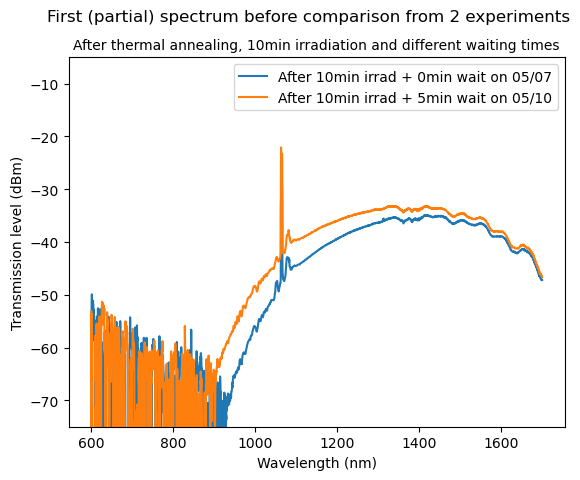

In [4]:
IDFILES = [0,0]
# IDFILES = [0,1]
# FIRST_IDS = [286,425]
FIRST_IDS = [287,288]
LABELS = ["After 10min irrad + 0min wait on 05/07","After 10min irrad + 5min wait on 05/10"]
extract_title = "First (partial) spectrum before comparison from 2 experiments"
smalltitle= "After thermal annealing, 10min irradiation and different waiting times"
filenameplot = "Comparison 05-10 05-07 - first spectrum before.png" 
SAVE=True

fig, ax = plt.subplots()
LINES = [ax.plot(WL_nm, DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID],label=LABELS[i]) for i,ID in enumerate(FIRST_IDS)]
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm)")
fig.suptitle(extract_title,fontsize=12)
# ax.set_title(f"Transmitted spectrum after {0*Tsweep:.1f} seconds of annealing",fontsize=10)
ax.set_title(smalltitle,fontsize=10)
ax.set_ylim(-75, -5)
ax.legend()
if not(SAVE):
    plt.show()
if SAVE:
    plt.savefig(filenameplot)

# Filter testing

### Filtering functions

https://doi.org/10.1021/acsmeasuresciau.1c00054

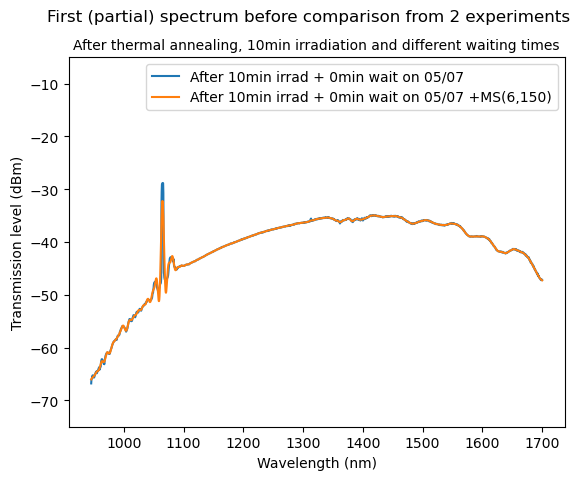

In [5]:
IDFILES = [0]
# IDFILES = [0,1]
# FIRST_IDS = [286,425]
FIRST_IDS = [287]
test_data = DIC_fprop[IDFILES[0]]["Id2LEVEL"][FIRST_IDS[0]]
LABELS = ["After 10min irrad + 0min wait on 05/07","After 10min irrad + 5min wait on 05/10"]
extract_title = "First (partial) spectrum before comparison from 2 experiments"
smalltitle= "After thermal annealing, 10min irradiation and different waiting times"
filenameplot = "Comparison 05-10 05-07 - first spectrum before.png" 
SAVE=False

n=6
m=150

fig, ax = plt.subplots()
LINES = [ax.plot(WL_nm[rmno.firstid(DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID]):], DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID][rmno.firstid(DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID]):],label=LABELS[i]) for i,ID in enumerate(FIRST_IDS)]
LINES+= [ax.plot(WL_nm[rmno.firstid(DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID]):],smoothMS(DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID][rmno.firstid(DIC_fprop[IDFILES[i]]["Id2LEVEL"][ID]):],n,m),label=LABELS[i]+f" +MS({n},{m})") for i,ID in enumerate(FIRST_IDS)]
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission level (dBm)")
fig.suptitle(extract_title,fontsize=12)
# ax.set_title(f"Transmitted spectrum after {0*Tsweep:.1f} seconds of annealing",fontsize=10)
ax.set_title(smalltitle,fontsize=10)
ax.set_ylim(-75, -5)
ax.legend()
if not(SAVE):
    plt.show()
if SAVE:
    plt.savefig(filenameplot)

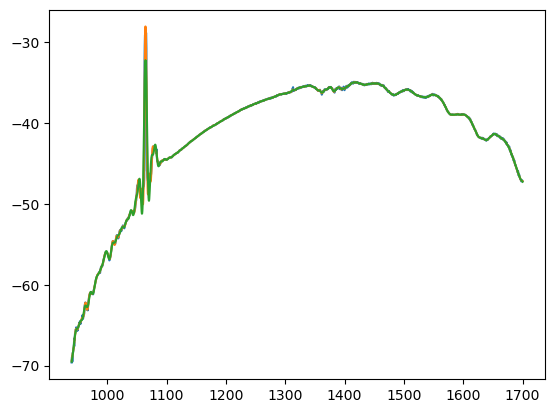

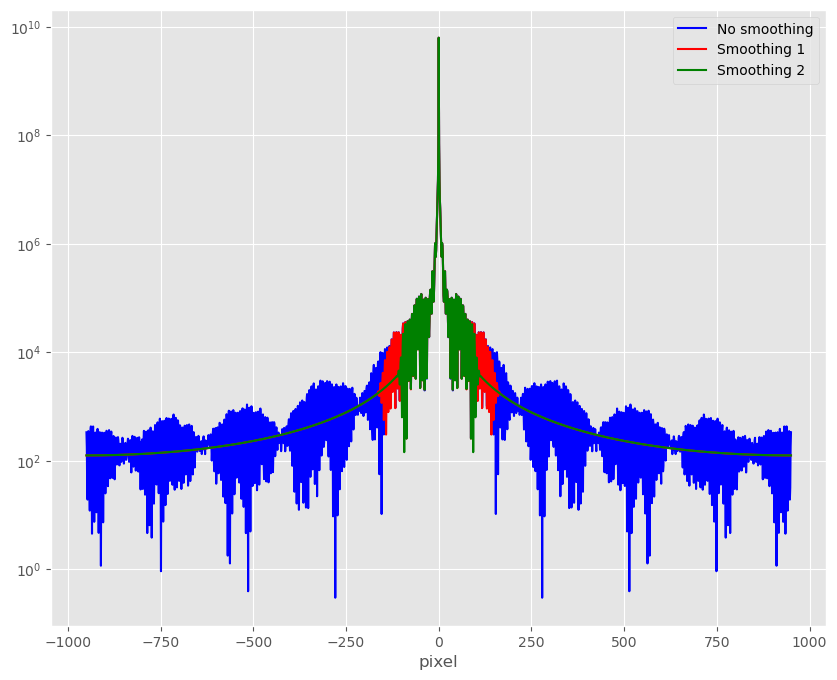

In [167]:
low,high=850,len(test_data)
# low,high=0,250
Y=WL_nm[low:high]
X=test_data[low:high]
X_smooth_1 = smoothMS(X,n=6,m=100)
X_smooth_2 = smoothMS(X,n=6,m=150)
plt.plot(Y,X)
plt.plot(Y,X_smooth_1)
plt.plot(Y,X_smooth_2)
plt.show()

ps = np.abs(np.fft.fftshift(np.fft.fft(X)))**2
ps_1 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_1)))**2
ps_2 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_2)))**2

# Define pixel in Fourier space
fpix = np.arange(ps.shape[0]) - ps.shape[0]//2
 
plt.figure(figsize=(10,8))
with plt.style.context(('ggplot')):
    plt.semilogy(fpix, ps, 'b', label = 'No smoothing')
    plt.semilogy(fpix, ps_1, 'r', label = 'Smoothing 1')
    plt.semilogy(fpix, ps_2, 'g', label = 'Smoothing 2')
    # plt.semilogy(fpix, ps_3, 'm', label = 'Smoothing 3')
    plt.legend()
    plt.xlabel('pixel')

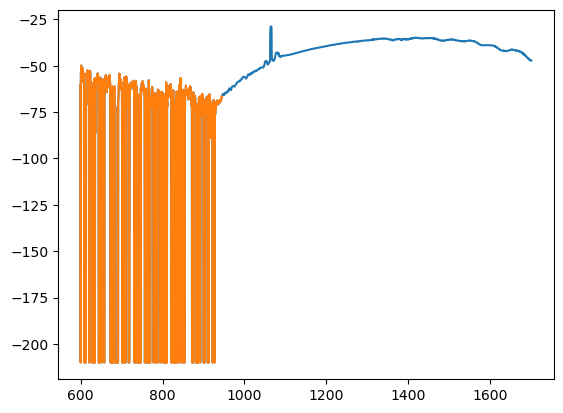

In [172]:
#Version with power spectrum
# half_width_test = 200
# MIRRORED = np.zeros(len(test_data)+2*half_width_test)
# MIRRORED[half_width_test:half_width_test+len(test_data)]=test_data
# MIRRORED[:half_width_test]=test_data[:half_width_test][::-1]
# MIRRORED[-width_test:]=test_data[-width_test:][::-1]
# TESTF = np.array([np.mean(np.abs(np.fft.fftshift(np.fft.fft(MIRRORED[half_width_test+i:i+2*half_width_test])))**2) for i in range(len(test_data))])
# TESTF_bool = TESTF < 7e5
# plt.plot(WL_nm,TESTF)
# plt.show()

# Version with values at low peaks
# half_width_test = 40
# noise_threshold = -75 #dB
# extdata = np.zeros(len(test_data)+2*half_width_test)
# extdata[half_width_test:half_width_test+len(test_data)]=test_data
# TESTF_bool = np.array([not(np.any(extdata[i:i+2*half_width_test] < noise_threshold)) for i in range(len(test_data))])

# def firstid_nonoise(data, half_width_test = 40, noise_threshold = -75):
#     extdata = np.zeros(len(data)+2*half_width_test)
#     extdata[half_width_test:half_width_test+len(data)]=data
#     TESTF_bool = [not(np.any(extdata[i:i+2*half_width_test] < noise_threshold)) for i in range(len(data))]
#     return next(id for id,bool in enumerate(TESTF_bool) if bool)
# firstid = firstid_nonoise(test_data)

# plt.plot(WL_nm,test_data)
# plt.plot(np.array(WL_nm)[:firstid],test_data[:firstid])
# plt.show()

In [8]:
try:
    next(id for id,bool in enumerate([False,False,False]) if bool)
except StopIteration:
    print("Coucou")

Coucou
